IMPORT:

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

import os

import matplotlib.pyplot as plt
import seaborn as sns

Loading Datasets

In [7]:
train_df = pd.read_csv('datasets/kaggle/application_train.csv')
test_df = pd.read_csv('datasets/kaggle/application_test.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/kaggle/application_train.csv'

# Preprocessing

In [12]:
le = LabelEncoder()
le_count = 0

for col in train_df:
    if train_df[col].dtype == 'object':
        if len(list(train_df[col].unique())) <= 2:
            le.fit(train_df[col])
            train_df[col] = le.transform(train_df[col])
            test_df[col] = le.transform(test_df[col])
            le_count += 1

train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)


In [13]:
labels = train_df['TARGET']

train_df, test_df = train_df.align(test_df, join = 'inner', axis = 1)

train_df['TARGET'] = labels

Text(0.5, 0, 'Days Employment')

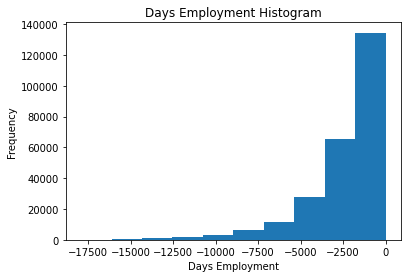

In [14]:
train_df['DAYS_EMPLOYED_ANOM'] = train_df["DAYS_EMPLOYED"] == 365243
train_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

train_df['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

In [15]:
test_df['DAYS_EMPLOYED_ANOM'] = test_df["DAYS_EMPLOYED"] == 365243
test_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

In [16]:
correlations = train_df.corr()['TARGET'].sort_values()

In [17]:
print(correlations.head(20))

EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
DAYS_EMPLOYED_ANOM                     -0.045987
ORGANIZATION_TYPE_XNA                  -0.045987
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
FLOORSMAX_MODE                         -0.043226
EMERGENCYSTATE_MODE_No                 -0.042201
HOUSETYPE_MODE_block of flats          -0.040594
AMT_GOODS_PRICE                        -0.039645
REGION_POPULATION_RELATIVE             -0.037227
ELEVATORS_AVG                          -0.034199
ELEVATORS_MEDI                         -0.033863
FLOORSMIN_AVG                          -0.033614
FLOORSMIN_MEDI                         -0.033394
WALLSMATERIAL_MODE_Panel               -0.033119
Name: TARGET, dtype:

In [18]:
print(correlations.tail(20))

DEF_60_CNT_SOCIAL_CIRCLE                             0.031276
DEF_30_CNT_SOCIAL_CIRCLE                             0.032248
LIVE_CITY_NOT_WORK_CITY                              0.032518
OWN_CAR_AGE                                          0.037612
DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_R

In [24]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

if 'TARGET' in train_df:
    train = train_df.drop(columns = ['TARGET'])
else:
    train = train_df.copy()
    
features = list(train.columns)

test = test_df.copy()

imputer = SimpleImputer(strategy = 'median')

scaler = MinMaxScaler(feature_range = (0, 1))

imputer.fit(train)

train = imputer.transform(train)
test = imputer.transform(test_df)

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 243)
Testing data shape:  (48744, 243)


In [26]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C = 0.0001)
log_reg.fit(train, labels)

LogisticRegression(C=0.0001)

In [27]:
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [28]:
submit = test_df[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

<ipython-input-28-f14bf8c77dec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['TARGET'] = log_reg_pred


SK_ID_CURR    TARGET
0      100001  0.079882
1      100005  0.140745
2      100013  0.081459
3      100028  0.082173
4      100038  0.130224

In [29]:
submit.to_csv('log_reg_baseline.csv', index = False)